# 18-13. 프로젝트: 뉴스기사 요약해보기

## Step 1. 데이터 수집하기

* 데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용하세요.
* sunnysai12345/News_Summary
* https://github.com/sunnysai12345/News_Summary

In [1]:
import pandas as pd
import urllib.request

# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [2]:
data.sample(10)

,headlines,text
42914,Lone survivor lying about seeing 39 Indians ge...,External Affairs Minister Sushma Swaraj has sa...
56998,iPhone X-like Face ID on Android phones Ã¢ÂÂ...,Talking about Android smartphones using iPhone...
12081,Smith debuts on Australian young rich list des...,"Australian cricketer Steve Smith, who is curre..."
82519,US company pays up to Ã¢ÂÂ¹12 lakh for its em...,"Chieh Huang, the CEO of American company Boxed..."
516,India's bullet train to say 'sorry' even if it...,"India's bullet train service will say ""sorry"" ..."
84621,Ex-London mayor's 'get stuffed' clip emerges p...,A 2013 video of the then London Mayor Boris Jo...
70648,Pahlaj's erotic thriller Julie 2 passed by CBF...,"Erotic thriller 'Julie 2', which is being pres..."
77688,Qatar complains to WTO against Saudi-led trade...,Qatar on Monday filed a legal complaint at the...
95755,AB de Villiers gets injured ahead of the IPL 2017,South African batsman AB de Villiers was ruled...
60186,No Arab capital safe from Iran's missiles: Sau...,"Urging fellow Arab League nations to find a ""n..."


* 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성됨

추상적 요약을 하는 경우에는 
* text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 

추출적 요약을 하는 경우에는 
* 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)

* 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 
* 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요

In [4]:
# 패키지 호출
import nltk
nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0042/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 데이터 전처리 - 중복 제거, NULL 제거

In [5]:
# 전체 data 수 확인
print('전체 data 수 : ', len(data))

전체 data 수 :  98401


In [6]:
# 각 열별 유일한 샘플 수 확인
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [9]:
# 중복 값 제거
data.drop_duplicates(subset = ['headlines'], inplace = True)
data.drop_duplicates(subset = ['text'], inplace = True)

# 중복 제거 후 전체 data갯수 확인
print('중복 제거 후 전체 샘플수 :', len(data))

중복 제거 후 전체 샘플수 : 98262


In [10]:
# 열별 null 갯수 확인 
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


=> 제거할 null 없음

### 텍스트 정규화, 불용어 제거

### 텍스트 정규화(text normalization)

* 기계 학습 전에 '같은 의미 다른 표현 단어'를 미리 같은 표현으로 통일시켜주는 것
* 예시 'it'll'은 'it will'과 같고, 'mustn't과 'must not'은 사실 같은 표현

* 여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성
* 이 사전은 아래의 링크에서 참고하여 만들었어요. 정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [11]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120



### 불용어(stopwords) 제거

* 불용어 : 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어
* 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 것


In [12]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

* 텍스트 정규화, 불용어 제거 수행하는 전처리 함수 설계

In [13]:
# 데이터 전처리 함수
# 함수의 2번째 인자를 False로 설정하면 불용어는 제거되지 않음
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
# data[text]에 대하여 함수 실행

clean_text = []

# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있음. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [15]:
# data[headlines]에 대하여 함수 실행
clean_headlines = []

# 전체 data[headlines] 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있음. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))
    # headlines에 대해서 전처리 함수를 호출해줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두번째 인자로 False를 넣음
    
clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [16]:
# 다시 data 변수에 넣어주기
data['text'] = clean_text
data['headlines'] = clean_headlines

### 전처리(정규화, 불용어 제거) 후 NULL 값 재확인 및 제거

In [18]:
# 빈 값('')을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# Null 값 존재 재확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

=> Null 없음

### 샘플 최대 길이 설정

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299444342675704
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326


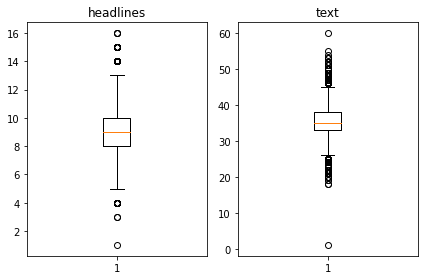

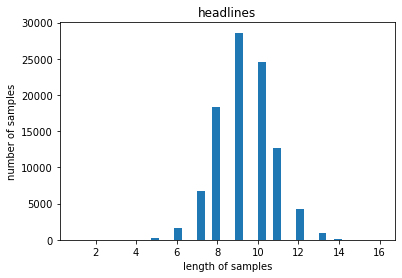

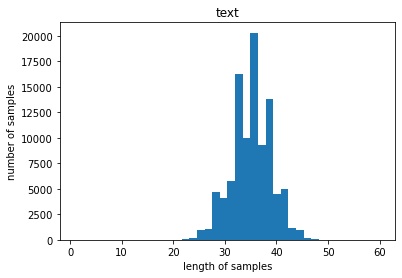

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]


print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
# headlines와 text의 적절한 최대 길이를 지정
headlines_max_len = 12
text_max_len = 45

In [26]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [27]:
# 지정한 최대 길이가 몇 % 샘플을 포함하는지 확인
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880319960920804
전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967739309193788


In [28]:
# 정한 길이 보다 길면 데이터 제외하는 방식으로 정제
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('현재 전체 샘플수 :',(len(data)))

현재 전체 샘플수 : 96774


### 시작 토큰과 종료 토큰 추가하기

* 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명
* decoder_input : 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름
* decoder_target : 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름

In [29]:
# 헤드라인 데이터에 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [30]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터를 분리

In [31]:
# encoder_input의 데이터 갯수와 같은 정수 시퀀스 만들기
# (이 정수 시퀀스를 이용해서 샘플 데이터를 섞기 수행)

indices = np.arange(encoder_input.shape[0])
# np.arange : 시작 숫자와 끝 숫자를 주어주면 일정한 간격의 배열을 만들어줌

# 순서를 섞어줌
np.random.shuffle(indices)
print(indices)

[59885 45408 18213 ... 33723 45650 42132]


In [32]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의
# 리스트를 이용해 순서 섞기!!!
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [33]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
# n_of_val : 테스트 데이터의 수
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19354


In [34]:
# 데이터 분리 수행
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77420
훈련 레이블의 개수 : 77420
테스트 데이터의 개수 : 19354
테스트 레이블의 개수 : 19354


In [36]:
# 데이터 확인
print(encoder_input_train[0])

rohtak jail prisoner currently bail revealed rape convict gurmeet ram rahim participate jail work comes reports claimed ram rahim earning per day spending eight hours cultivating vegetables jail also allowed meet visitors hours prisoner claimed


### 정수 인코딩
    * Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있음

In [37]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [38]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합


temp = 0  # key, value 값 확인용 변수

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# key : Tokenizer에 포함된 단어
# value : 각 단어별 등장 빈도 수
for key, value in src_tokenizer.word_counts.items():   
    
    # key, value 값 확인용 코드
    if temp <= 3:
        print('key : ', key)
        print('value : ', value)
        print(type(value))
        temp += 1
        
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면(6번 이하로 등장한 단어는 제외)
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

key :  rohtak
value :  44
<class 'int'>
key :  jail
value :  893
<class 'int'>
key :  prisoner
value :  47
<class 'int'>
key :  currently
value :  1178
<class 'int'>
단어 집합(vocabulary)의 크기 : 69152
등장 빈도가 6번 이하인 희귀 단어의 수: 47170
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21982
단어 집합에서 희귀 단어의 비율: 68.21205460434983
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5166086839922137


In [39]:
# num_words를 설정하여 토크나이저를 정의할 때 단어 집합의 크기를 제한
src_vocab = 21900
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 21,900으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [40]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [41]:
#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[7589, 512, 7302, 353, 1213, 84, 451, 3917, 3568, 343, 2113, 2687, 512, 139, 63, 30, 42, 343, 2113, 4294, 123, 41, 2611, 372, 272, 6900, 512, 6, 492, 708, 2750, 272, 7302, 42], [81, 934, 1697, 151, 2725, 10163, 1615, 183, 15, 4610, 1571, 4529, 948, 212, 81, 22, 5378, 18226, 523, 15, 886, 233, 602, 10374, 15, 383, 154, 389], [38, 1075, 14182, 61, 318, 12490, 2088, 850, 270, 2550, 506, 242, 1192, 5175, 141, 170, 1235, 754, 36, 1392, 809, 1150, 6473, 2550, 506, 1385]]


### headlines 데이터 정수 인코딩

In [42]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [43]:
# 등장 횟수 5회 이하 분포율 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29847
등장 빈도가 5번 이하인 희귀 단어의 수: 19513
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10334
단어 집합에서 희귀 단어의 비율: 65.37675478272523
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.705285116117362


In [44]:
# 10334를 어림잡아 10000개로 설정
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 45, 122, 76, 1035, 131, 234, 6425, 232, 7158, 7, 303, 1219], [1, 428, 159, 17, 2081, 7617, 13, 56, 260, 2806, 286], [1, 33, 1068, 372, 7618, 3, 1434, 332, 613, 93], [1, 1832, 2110, 5150, 3, 7619, 5, 64], [1, 2185, 7620, 96, 3770, 491, 7, 365, 5, 31]]
target
decoder  [[45, 122, 76, 1035, 131, 234, 6425, 232, 7158, 7, 303, 1219, 2], [428, 159, 17, 2081, 7617, 13, 56, 260, 2806, 286, 2], [33, 1068, 372, 7618, 3, 1434, 332, 613, 93, 2], [1832, 2110, 5150, 3, 7619, 5, 64, 2], [2185, 7620, 96, 3770, 491, 7, 365, 5, 31, 2]]


* 빈도수 낮은 단어 제거 후 Null data 확인

In [45]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


=> NULL data 없음

### 패딩하기

* 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 작업
* 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이를 맞춰줆

In [46]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

* 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 
* 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [49]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [50]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [51]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2803200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [52]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [53]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2803200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [54]:
# 설계한 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
303/303 [==============================] - 95s 315ms/step - loss: 5.6058 - val_loss: 5.2011
Epoch 2/50
303/303 [==============================] - 94s 312ms/step - loss: 5.0452 - val_loss: 4.8312
Epoch 3/50
303/303 [==============================] - 96s 317ms/step - loss: 4.6879 - val_loss: 4.5277
Epoch 4/50
303/303 [==============================] - 98s 322ms/step - loss: 4.4209 - val_loss: 4.3319
Epoch 5/50
303/303 [==============================] - 97s 320ms/step - loss: 4.2130 - val_loss: 4.2000
Epoch 6/50
303/303 [==============================] - 97s 320ms/step - loss: 4.0412 - val_loss: 4.0730
Epoch 7/50
303/303 [==============================] - 97s 320ms/step - loss: 3.8927 - val_loss: 3.9981
Epoch 8/50
303/303 [==============================] - 97s 320ms/step - loss: 3.7629 - val_loss: 3.9036
Epoch 9/50
303/303 [==============================] - 95s 314ms/step - loss: 3.6507 - val_loss: 3.8524
Epoch 10/50
303/303 [==============================] - 93s 306ms/step - l

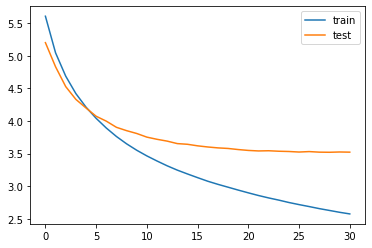

In [55]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 18-10. 인퍼런스 모델 구현하기

    * 인퍼런스 모델 : 훈련 할 때 모델과 다른 실제 동작 모델

In [56]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [57]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [58]:
# 어텐션 메커니즘을 사용하는 출력층을 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [62]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 설계

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

* 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

In [63]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [64]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : uttar pradesh director general police op singh claimed fear criminals voluntarily cancelling bail pleas surrender state many criminals surrendered far added police issued instructions every district state nab criminals said 
실제 요약 : criminals are cancelling own bail and up dgp 
예측 요약 :  criminals will be arrested in jail for anti romeo squads dgp


원문 : windies defeated india wickets one kingston sunday chasing register highest successful chase home windies lewis became third batsman score two centuries cricket chris gayle first international match since april dinesh karthik featured seven years 
실제 요약 : windies defeat india by wickets in one off 
예측 요약 :  india beat windies to win their nd straight series win


원문 : designs nine year old english boy chosen upcoming iaaf world championships world para athletics championships hero bee chosen entries competition run organisers animals chosen winning designer since endangered species survivors 
실제 요약 : yr old designs chosen as for wo

예측 요약 :  uber ceo travis kalanick kalanick kalanick ex ceo


원문 : claiming favour ram mandir ayodhya samajwadi party founder mulayam singh yadav daughter law aparna yadav wednesday said bjp lord ram aparna contest general elections uncle shivpal singh samajwadi party added full faith process respected court 
실제 요약 : am with lord ram mulayam daughter in law on ram mandir 
예측 요약 :  ram mandir will be allowed to fight polls mulayam


원문 : ceremony white house tuesday us president donald trump said seriously thinking sixth military branch would space force us getting big space reasons added notably us signed treaty bans space warfare 
실제 요약 : seriously thinking of creating space force trump 
예측 요약 :  trump will not be in the us president donald trump


원문 : narayana murthy co founder giant infosys commented recent reports companies sacking employees part cost cutting strategies saying sad earlier infosys announced could lay mid senior level employees bi annual performance review comes amid

예측 요약 :  bjp minister calls bjp minister for tripura minister


원문 : th australia innings first india australia wednesday rounder glenn maxwell smashed krunal pandya delivery went hit spider ball fell inside yard circle hitting spider declared dead umpire krunal conceded runs four overs match 
실제 요약 : maxwell smashes ball into spider umpire declares dead ball 
예측 요약 :  bowler who was the longest wicket hit wicket in australia


원문 : australian researchers discovered year old spider recently died previous world record holder year old found mexico research project initiated barbara york main monitored long term spider population years region western australia said university researcher mason 
실제 요약 : world oldest known spider dies aged in australia 
예측 요약 :  oldest man aged oldest ever to be world oldest


원문 : slammed tweet wherein described morning azaan played loudspeakers extreme imposed singer suchitra krishnamoorthi said sonu nigam tweet azaan area become louder almost like retalia

## Step 5. Summa을 이용해서 추출적 요약해보기

* 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 
* 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

* Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [114]:
# 패키지 설치
import requests
from summa.summarizer import summarize

In [126]:
# 요약할 text 저장
origin_text = data['text'][26]
print('원본 문장 : ', origin_text)

원본 문장 :  london zoo offering people name cockroach exes valentine day quite require revenge another way make feel better getting back ex zoo said statement names appear zoo roach board february


In [120]:
#  headlines 원본 출력
origin_headlines = data['headlines'][20]
print('원본 headlines : ', origin_headlines)

원본 headlines :  think the opposition even dreams about me pm modi


In [128]:
#  summa를 사용한 요약본 출력
print('추출적 요약본 : ')
print(summarize(origin_text, ratio=0.2))

추출적 요약본 : 

